In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import warnings
from prophet import Prophet
import datetime
import os
from scipy import stats
import matplotlib.dates as mdates

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style and figure size
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print("Libraries imported and configurations set.")

Libraries imported and configurations set.


In [11]:
def load_and_preprocess_data(file_path, row_limit=None):
    print("Loading and preprocessing data...")
    print(f"Row limit set to: {'All rows' if row_limit is None else row_limit}")
    
    # Define column names for the dataset
    column_names = ['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
                    'Voltage', 'Global_intensity', 'Sub_metering_1',
                    'Sub_metering_2', 'Sub_metering_3']
    
    # Load the dataset with correct column names and data types
    df = pd.read_csv(file_path, sep=';', header=0, names=column_names, 
                     parse_dates={'datetime': ['Date', 'Time']},
                     dayfirst=True, na_values=['?'], nrows=row_limit)
    
    # Convert 'datetime' column to datetime format
    df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M:%S')
    
    # Set datetime as index
    df.set_index('datetime', inplace=True)
    
    # Check for missing values
    print(f"Missing values before interpolation:\n{df.isnull().sum()}")
    
    # Handle missing values using linear interpolation
    df = df.interpolate(method='linear')
    
    # Check if there are any remaining missing values
    print(f"Missing values after interpolation:\n{df.isnull().sum()}")
    
    # Calculate total consumption (excluding what's measured by submeters)
    df['Other_consumption'] = (df['Global_active_power'] * 1000 / 60) - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])
    
    # Replace any remaining NaN values with the median of the respective column
    for col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Filter out any outliers using z-score
    for col in df.select_dtypes(include=np.number).columns:
        z_scores = stats.zscore(df[col])
        abs_z_scores = np.abs(z_scores)
        df = df[abs_z_scores < 5]  # Keep only rows with z-score < 5
    
    # Show dataset info
    print(f"\nDataset shape after preprocessing: {df.shape}")
    print("\nDataset columns:", df.columns.tolist())
    print("\nDataset sample:\n", df.head())
    
    return df

In [12]:
def engineer_features(df):
    print("\nPerforming feature engineering...")
    
    # Time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Create season feature (1: Winter, 2: Spring, 3: Summer, 4: Fall)
    df['season'] = df['month'].apply(lambda x: 1 if x in [12, 1, 2] else
                                  (2 if x in [3, 4, 5] else
                                   (3 if x in [6, 7, 8] else 4)))
    
    # Create part of day feature
    def get_part_of_day(hour):
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'
    
    df['part_of_day'] = df.index.hour.map(get_part_of_day)
    
    # Create lag features for autoregressive modeling
    for lag in [1, 6, 12, 24]:
        df[f'Global_active_power_lag_{lag}h'] = df['Global_active_power'].shift(lag)
    
    # Create rolling window features (averages over different periods)
    for window in [6, 12, 24]:
        df[f'Global_active_power_rolling_{window}h'] = df['Global_active_power'].rolling(window=window).mean()
    
    # Drop NaN values that resulted from creating lag features
    df.dropna(inplace=True)
    
    print("Feature engineering complete.")
    print("Engineered features:", [col for col in df.columns if col not in ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                                                                       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 
                                                                       'Sub_metering_3', 'Other_consumption']])
    
    return df

In [13]:
def perform_eda(df):
    print("\nPerforming Exploratory Data Analysis...")
    
    # 1. Distribution of energy consumption
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    sns.histplot(df['Global_active_power'], kde=True)
    plt.title('Distribution of Global Active Power')
    plt.xlabel('Global Active Power (kilowatts)')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df['Global_active_power'])
    plt.title('Boxplot of Global Active Power')
    plt.ylabel('Global Active Power (kilowatts)')
    plt.tight_layout()
    plt.show()
    
    # 2. Daily patterns
    daily_consumption = df.groupby(df.index.hour)['Global_active_power'].mean()
    plt.figure(figsize=(12, 6))
    daily_consumption.plot(kind='line', marker='o')
    plt.title('Average Power Consumption by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Global Active Power (kilowatts)')
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.show()
    
    # 3. Weekly patterns
    weekly_consumption = df.groupby(df.index.dayofweek)['Global_active_power'].mean()
    plt.figure(figsize=(12, 6))
    weekly_consumption.plot(kind='bar')
    plt.title('Average Power Consumption by Day of Week')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Global Active Power (kilowatts)')
    plt.xticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.grid(True, axis='y')
    plt.show()
    
    # 4. Monthly patterns
    monthly_consumption = df.groupby(df.index.month)['Global_active_power'].mean()
    plt.figure(figsize=(12, 6))
    monthly_consumption.plot(kind='bar')
    plt.title('Average Power Consumption by Month')
    plt.xlabel('Month')
    plt.ylabel('Global Active Power (kilowatts)')
    plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, axis='y')
    plt.show()
    
    # 5. Correlation between features
    plt.figure(figsize=(14, 12))
    numeric_df = df.select_dtypes(include=[np.number])
    correlation = numeric_df.corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5)
    plt.title('Correlation Matrix of Features')
    plt.tight_layout()
    plt.show()
    
    # 6. Submeter breakdown - Energy distribution
    submeter_data = df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Other_consumption']].mean()
    plt.figure(figsize=(10, 10))
    plt.pie(submeter_data, labels=['Kitchen', 'Laundry Room', 'Water Heater & AC', 'Other'], 
            autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('Distribution of Energy Consumption by Appliance Type')
    plt.axis('equal')
    plt.show()
    
    # 7. Time series plot for a sample week
    sample_week = df.iloc[-7*24*60:].resample('H').mean(numeric_only=True)
    plt.figure(figsize=(18, 10))
    plt.plot(sample_week.index, sample_week['Global_active_power'], label='Global Active Power')
    plt.plot(sample_week.index, sample_week['Sub_metering_1']/50, label='Kitchen')
    plt.plot(sample_week.index, sample_week['Sub_metering_2']/50, label='Laundry Room')
    plt.plot(sample_week.index, sample_week['Sub_metering_3']/50, label='Water Heater & AC')
    plt.title('Energy Consumption Over a Sample Week')
    plt.xlabel('Date')
    plt.ylabel('Power')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 8. Anomaly Detection
    rolling_mean = df['Global_active_power'].rolling(window=24).mean()
    rolling_std = df['Global_active_power'].rolling(window=24).std()
    upper_bound = rolling_mean + 3 * rolling_std
    lower_bound = rolling_mean - 3 * rolling_std
    anomalies = df[(df['Global_active_power'] > upper_bound) | (df['Global_active_power'] < lower_bound)]
    sample_month = df.iloc[-30*24*60:].resample('H').mean(numeric_only=True)
    sample_month_anomalies = anomalies.loc[sample_month.index[0]:sample_month.index[-1]].resample('H').mean(numeric_only=True)
    plt.figure(figsize=(18, 10))
    plt.plot(sample_month.index, sample_month['Global_active_power'], label='Global Active Power', color='blue', alpha=0.7)
    plt.scatter(sample_month_anomalies.index, sample_month_anomalies['Global_active_power'], 
                color='red', label='Anomalies', s=100, zorder=5)
    plt.title('Anomaly Detection in Energy Consumption')
    plt.xlabel('Date')
    plt.ylabel('Global Active Power (kilowatts)')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 9. Energy consumption by season
    seasonal_consumption = df.groupby('season')['Global_active_power'].mean()
    plt.figure(figsize=(12, 6))
    season_names = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    seasonal_consumption.index = [season_names[i] for i in seasonal_consumption.index]
    seasonal_consumption.plot(kind='bar', color='skyblue')
    plt.title('Average Power Consumption by Season')
    plt.xlabel('Season')
    plt.ylabel('Global Active Power (kilowatts)')
    plt.grid(True, axis='y')
    plt.show()
    
    # 10. Consumption patterns by part of day
    part_day_consumption = df.groupby('part_of_day')['Global_active_power'].mean().reindex(['Morning', 'Afternoon', 'Evening', 'Night'])
    plt.figure(figsize=(12, 6))
    part_day_consumption.plot(kind='bar', color='lightgreen')
    plt.title('Average Power Consumption by Part of Day')
    plt.xlabel('Part of Day')
    plt.ylabel('Global Active Power (kilowatts)')
    plt.grid(True, axis='y')
    plt.show()
    
    # 11. Weekday vs. Weekend Consumption
    weekday_weekend = df.groupby('is_weekend')['Global_active_power'].mean()
    plt.figure(figsize=(10, 6))
    weekday_weekend.index = ['Weekday', 'Weekend']
    weekday_weekend.plot(kind='bar', color=['lightsalmon', 'lightblue'])
    plt.title('Weekday vs. Weekend Power Consumption')
    plt.xlabel('')
    plt.ylabel('Global Active Power (kilowatts)')
    plt.grid(True, axis='y')
    plt.show()
    
    print("EDA completed. Plots displayed inline.")
    return anomalies

In [14]:
def scale_features(df):
    print("\nScaling features...")
    
    # Select numerical columns for scaling
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    
    # Initialize the scaler
    scaler = MinMaxScaler()
    
    # Scale numerical features
    df_scaled = df.copy()
    df_scaled[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    
    print("Features scaled successfully.")
    
    return df_scaled, scaler

In [15]:
def prepare_for_modeling(df, target_col='Global_active_power', forecast_horizon=24):
    print("\nPreparing data for modeling...")
    
    # Select relevant columns
    relevant_cols = [col for col in df.columns if (col.startswith(target_col) or 
                                                 col in ['hour', 'day_of_week', 'month', 'season', 'is_weekend'])]
    
    # Create feature set
    X = df[relevant_cols]
    y = df[target_col]
    
    # Split into train and test
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    print(f"Training set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [16]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, df):
    print("\nTraining and evaluating models...")
    
    # Model 1: XGBoost Regressor
    print("\n1. Training XGBoost Regressor...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    xgb_model.fit(X_train, y_train)
    xgb_preds = xgb_model.predict(X_test)
    
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
    xgb_mae = mean_absolute_error(y_test, xgb_preds)
    xgb_r2 = r2_score(y_test, xgb_preds)
    
    print(f"XGBoost RMSE: {xgb_rmse:.4f}")
    print(f"XGBoost MAE: {xgb_mae:.4f}")
    print(f"XGBoost R²: {xgb_r2:.4f}")
    
    plt.figure(figsize=(12, 8))
    xgb.plot_importance(xgb_model, max_num_features=15, height=0.8)
    plt.title('Feature Importance in XGBoost Model')
    plt.tight_layout()
    plt.show()
    
    # Model 2: ARIMA
    print("\n2. Training ARIMA model...")
    hourly_data = df['Global_active_power'].resample('H').mean()
    train_size = int(len(hourly_data) * 0.8)
    train_arima = hourly_data[:train_size]
    test_arima = hourly_data[train_size:]
    
    try:
        arima_model = ARIMA(train_arima, order=(2,1,2))
        arima_fit = arima_model.fit()
        forecast_steps = len(test_arima)
        arima_forecast = arima_fit.forecast(steps=forecast_steps)
        
        arima_rmse = np.sqrt(mean_squared_error(test_arima, arima_forecast))
        arima_mae = mean_absolute_error(test_arima, arima_forecast)
        
        print(f"ARIMA RMSE: {arima_rmse:.4f}")
        print(f"ARIMA MAE: {arima_mae:.4f}")
        
        plt.figure(figsize=(14, 7))
        plt.plot(train_arima.index[-100:], train_arima.values[-100:], label='Historical Data')
        plt.plot(test_arima.index, test_arima.values, label='Actual Values')
        plt.plot(test_arima.index, arima_forecast, label='ARIMA Forecast', color='red')
        plt.title('ARIMA Time Series Forecast')
        plt.xlabel('Date')
        plt.ylabel('Global Active Power (kilowatts)')
        plt.legend()
        plt.grid(True)
        plt.show()
    except:
        print("ARIMA model fitting failed. This could be due to non-stationarity or other time series issues.")
    
    # Model 3: Prophet
    print("\n3. Training Facebook Prophet model...")
    try:
        prophet_data = hourly_data.reset_index()
        prophet_data.columns = ['ds', 'y']
        prophet_train = prophet_data.iloc[:train_size]
        prophet_test = prophet_data.iloc[train_size:]
        
        prophet_model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True
        )
        prophet_model.fit(prophet_train)
        
        future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='H')
        forecast = prophet_model.predict(future)
        prophet_preds = forecast.iloc[-len(prophet_test):]['yhat'].values
        
        prophet_rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_preds))
        prophet_mae = mean_absolute_error(prophet_test['y'], prophet_preds)
        
        print(f"Prophet RMSE: {prophet_rmse:.4f}")
        print(f"Prophet MAE: {prophet_mae:.4f}")
        
        prophet_fig = prophet_model.plot_components(forecast)
        plt.show()
        
        plt.figure(figsize=(14, 7))
        plt.plot(prophet_train['ds'].iloc[-100:], prophet_train['y'].iloc[-100:], label='Historical Data')
        plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual Values')
        plt.plot(prophet_test['ds'], prophet_preds, label='Prophet Forecast', color='green')
        plt.title('Prophet Time Series Forecast')
        plt.xlabel('Date')
        plt.ylabel('Global Active Power (kilowatts)')
        plt.legend()
        plt.grid(True)
        plt.show()
    except:
        print("Prophet model fitting failed.")
    
    print("\nModel Performance Comparison:")
    print(f"XGBoost RMSE: {xgb_rmse:.4f}")
    try:
        print(f"ARIMA RMSE: {arima_rmse:.4f}")
        print(f"Prophet RMSE: {prophet_rmse:.4f}")
    except:
        pass
    
    return xgb_model, xgb_preds, y_test

In [17]:
def generate_appliance_insights(df):
    print("\nGenerating appliance-specific insights...")
    
    daily_submeter = df.resample('D').mean(numeric_only=True)
    appliance_df = pd.DataFrame({
        'Kitchen': daily_submeter['Sub_metering_1'],
        'Laundry': daily_submeter['Sub_metering_2'],
        'HVAC': daily_submeter['Sub_metering_3'],
        'Other': daily_submeter['Other_consumption']
    })
    
    total_consumption = appliance_df.sum(axis=1)
    for col in appliance_df.columns:
        appliance_df[f'{col}_pct'] = (appliance_df[col] / total_consumption) * 100
    
    appliance_df['Highest_Consumer'] = appliance_df[['Kitchen', 'Laundry', 'HVAC', 'Other']].idxmax(axis=1)
    
    plt.figure(figsize=(16, 8))
    for col in ['Kitchen_pct', 'Laundry_pct', 'HVAC_pct', 'Other_pct']:
        plt.plot(appliance_df.index, appliance_df[col], label=col.split('_')[0])
    plt.title('Daily Percentage Contribution of Each Appliance to Total Consumption')
    plt.xlabel('Date')
    plt.ylabel('Percentage of Total Consumption (%)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    hourly_submeter = df.groupby(df.index.hour).mean(numeric_only=True)
    plt.figure(figsize=(16, 8))
    plt.plot(hourly_submeter.index, hourly_submeter['Sub_metering_1'], label='Kitchen')
    plt.plot(hourly_submeter.index, hourly_submeter['Sub_metering_2'], label='Laundry')
    plt.plot(hourly_submeter.index, hourly_submeter['Sub_metering_3'], label='HVAC')
    plt.plot(hourly_submeter.index, hourly_submeter['Other_consumption'], label='Other')
    plt.title('Average Hourly Consumption by Appliance Type')
    plt.xlabel('Hour of Day')
    plt.ylabel('Power Consumption')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, 24))
    plt.show()
    
    kitchen_peak = hourly_submeter['Sub_metering_1'].idxmax()
    laundry_peak = hourly_submeter['Sub_metering_2'].idxmax()
    hvac_peak = hourly_submeter['Sub_metering_3'].idxmax()
    other_peak = hourly_submeter['Other_consumption'].idxmax()
    
    print(f"Peak usage times by appliance:")
    print(f"Kitchen: {kitchen_peak}:00")
    print(f"Laundry: {laundry_peak}:00")
    print(f"HVAC: {hvac_peak}:00")
    print(f"Other appliances: {other_peak}:00")
    
    appliance_correlation = df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Other_consumption']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(appliance_correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Between Appliance Usage')
    plt.tight_layout()
    plt.show()
    
    season_names = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    seasonal_appliance = df.groupby('season')[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Other_consumption']].mean()
    season_labels = [season_names.get(s, str(s)) for s in seasonal_appliance.index]
    seasonal_appliance.index = season_labels
    
    plt.figure(figsize=(14, 10))
    seasonal_appliance.plot(kind='bar')
    plt.title('Seasonal Variation in Appliance Energy Consumption')
    plt.xlabel('Season')
    plt.ylabel('Average Power Consumption')
    plt.legend(['Kitchen', 'Laundry', 'HVAC', 'Other'])
    plt.grid(True, axis='y')
    plt.show()
    
    kitchen_potential_savings = hourly_submeter['Sub_metering_1'].max() - hourly_submeter['Sub_metering_1'].min()
    laundry_potential_savings = hourly_submeter['Sub_metering_2'].max() - hourly_submeter['Sub_metering_2'].min()
    hvac_potential_savings = hourly_submeter['Sub_metering_3'].max() - hourly_submeter['Sub_metering_3'].min()
    other_potential_savings = hourly_submeter['Other_consumption'].max() - hourly_submeter['Other_consumption'].min()
    
    print(f"\nPotential energy savings by optimizing usage times:")
    print(f"Kitchen appliances: {kitchen_potential_savings:.2f} units per hour")
    print(f"Laundry appliances: {laundry_potential_savings:.2f} units per hour")
    print(f"HVAC system: {hvac_potential_savings:.2f} units per hour")
    print(f"Other appliances: {other_potential_savings:.2f} units per hour")
    
    return kitchen_peak, laundry_peak, hvac_peak, other_peak

In [18]:
def generate_recommendations(df, kitchen_peak, laundry_peak, hvac_peak, other_peak):
    print("\nGenerating energy optimization recommendations...")
    
    laundry_savings = 0
    kitchen_savings = 0
    vampire_savings = 0
    off_peak_hours = list(range(0, 7)) + list(range(22, 24))
    assumed_peak_tariff = 0.20
    assumed_off_peak_tariff = 0.10
    tariff_difference = assumed_peak_tariff - assumed_off_peak_tariff
    
    laundry_consumption = df['Sub_metering_2'].mean()
    if laundry_peak not in off_peak_hours:
        laundry_savings = laundry_consumption * tariff_difference * 30
        print(f"1. Shifting laundry activities from {laundry_peak}:00 to off-peak hours (22:00-7:00)")
        print(f"   could save approximately ${laundry_savings:.2f} per month.")
    else:
        print("1. Laundry activities are already optimized for off-peak usage.")
    
    winter_hvac = df[df['season'] == 1]['Sub_metering_3'].mean()
    summer_hvac = df[df['season'] == 3]['Sub_metering_3'].mean()
    seasonal_difference = abs(winter_hvac - summer_hvac)

    if kitchen_peak in range(17, 21):
        kitchen_savings = df['Sub_metering_1'].mean() * 0.15 * 30
        print(f"3. Kitchen appliances are heavily used at {kitchen_peak}:00 (peak tariff time).")
        print("   Consider meal prepping during weekends or using energy-efficient cooking methods.")
        print(f"   Potential monthly savings: ${kitchen_savings:.2f}")

    night_consumption = df[(df.index.hour >= 1) & (df.index.hour <= 4)]['Other_consumption'].mean()
    if night_consumption > 1:
        vampire_savings = night_consumption * 0.7 * assumed_off_peak_tariff * 30
        print(f"4. Standby power consumption is {night_consumption:.2f} units during 1:00-4:00 AM.")
        print("   Consider using smart power strips to cut power to devices when not in use.")
        print(f"   Potential monthly savings: ${vampire_savings:.2f}")
    
    weekday_consumption = df[df['is_weekend'] == 0]['Global_active_power'].mean()
    weekend_consumption = df[df['is_weekend'] == 1]['Global_active_power'].mean()
    
    if weekend_consumption > weekday_consumption * 1.2:
        print("5. Weekend energy consumption is significantly higher than weekdays.")
        print("   Consider reviewing weekend activities for energy optimization.")
        print("   Potential strategies: Batch cooking, combined laundry loads, outdoor activities.")
    
    df['zscore'] = stats.zscore(df['Global_active_power'])
    anomalies = df[df['zscore'] > 3]
    
    if len(anomalies) > 0:
        anomaly_percentage = (len(anomalies) / len(df)) * 100
        print(f"6. Detected {len(anomalies)} anomalous consumption patterns ({anomaly_percentage:.2f}% of time periods).")
        print("   These could indicate inefficient appliance usage or malfunctions.")
        print("   Recommendation: Investigate appliances during these specific time periods.")
    
    print("\nGeneral Energy Efficiency Recommendations:")
    print(" - Replace incandescent bulbs with LED lighting (up to 75% energy savings for lighting)")
    print(" - Ensure proper sealing on refrigerator and freezer doors")
    print(" - Unplug chargers and appliances when not in use")
    print(" - Consider smart thermostats for optimized HVAC control")
    print(" - Regularly clean or replace HVAC filters (can improve efficiency by 5-15%)")
    
    try:
        savings_categories = ['Laundry Timing', 'HVAC Optimization', 'Kitchen Usage', 'Standby Power']
        estimated_savings = [
            laundry_savings,
            seasonal_difference * assumed_peak_tariff * 30 * 0.1,
            kitchen_savings,
            vampire_savings
        ]
        plt.figure(figsize=(12, 7))
        bars = plt.bar(savings_categories, estimated_savings, color=['skyblue', 'lightgreen', 'salmon', 'purple'])
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'${height:.2f}', ha='center', va='bottom')
        plt.title('Estimated Monthly Savings by Optimization Category')
        plt.ylabel('Estimated Savings ($)')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    except Exception as e:
        print(f"Couldn't generate savings chart due to missing data: {e}")

Energy Consumption Analysis and Prediction Pipeline
Loading and preprocessing data...
Row limit set to: 1000000
Missing values before interpolation:
Global_active_power      3990
Global_reactive_power    3990
Voltage                  3990
Global_intensity         3990
Sub_metering_1           3990
Sub_metering_2           3990
Sub_metering_3           3990
dtype: int64
Missing values after interpolation:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Dataset shape after preprocessing: (951561, 8)

Dataset columns: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Other_consumption']

Dataset sample:
                      Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   

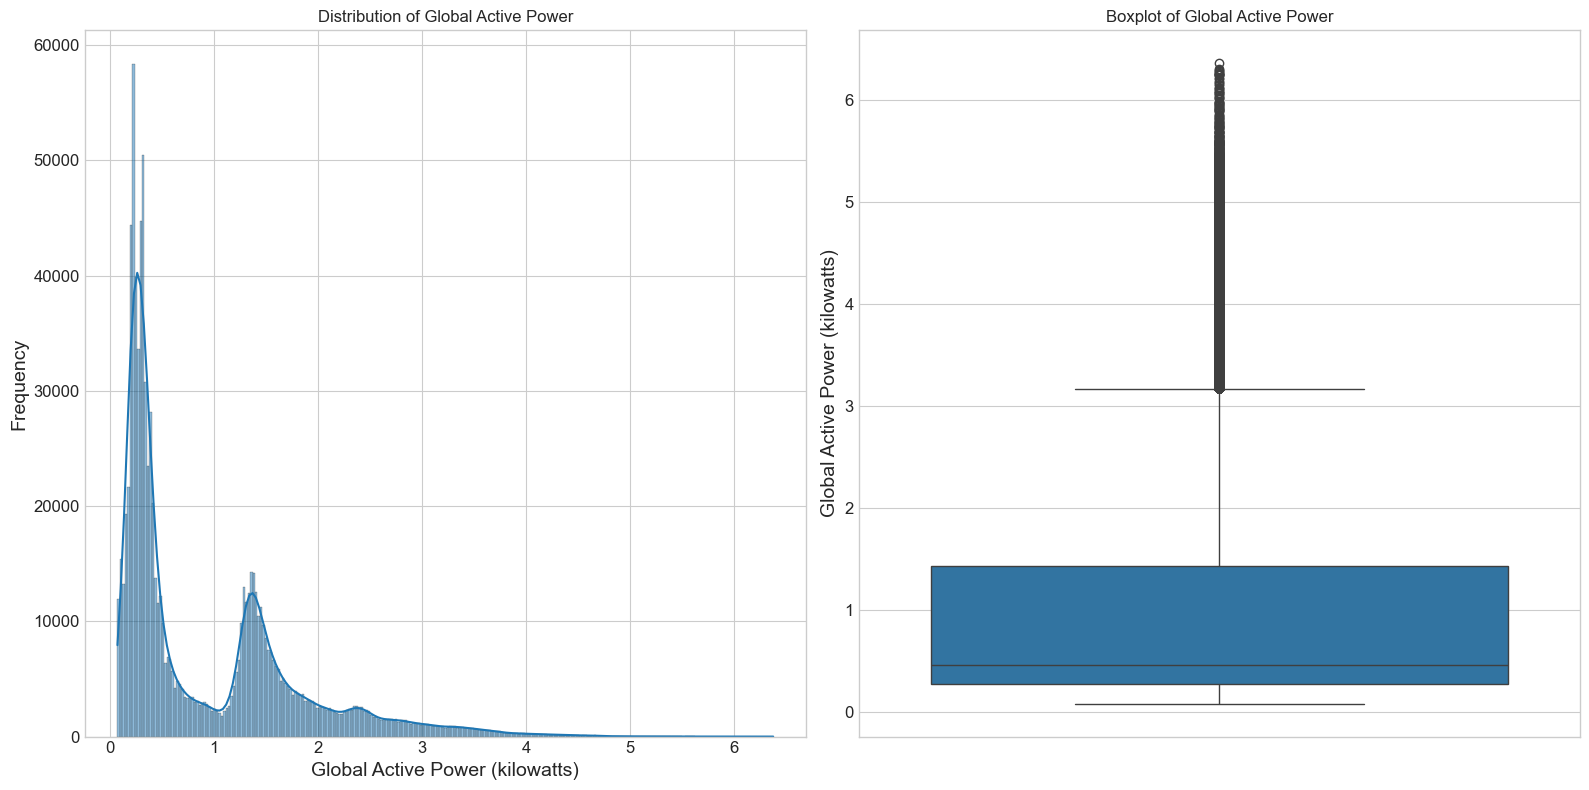

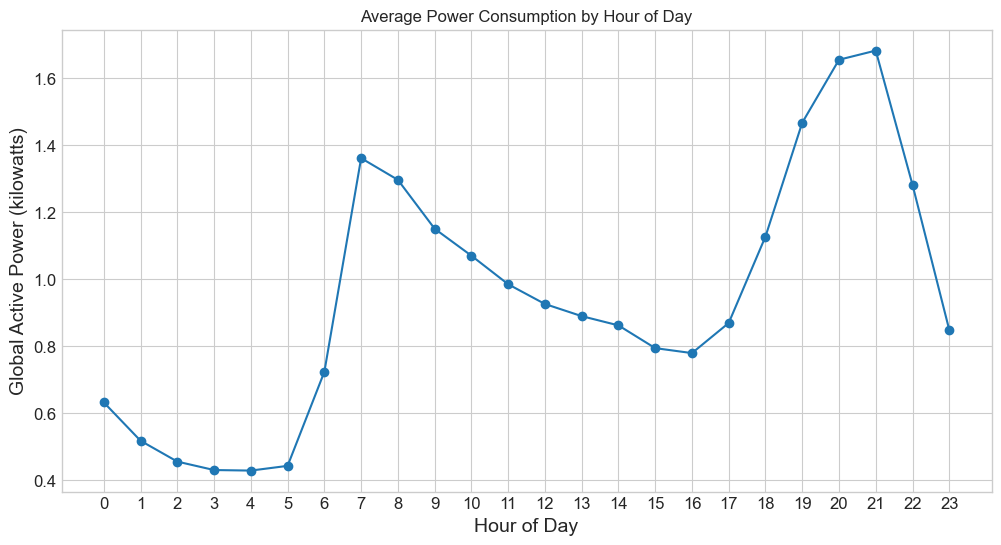

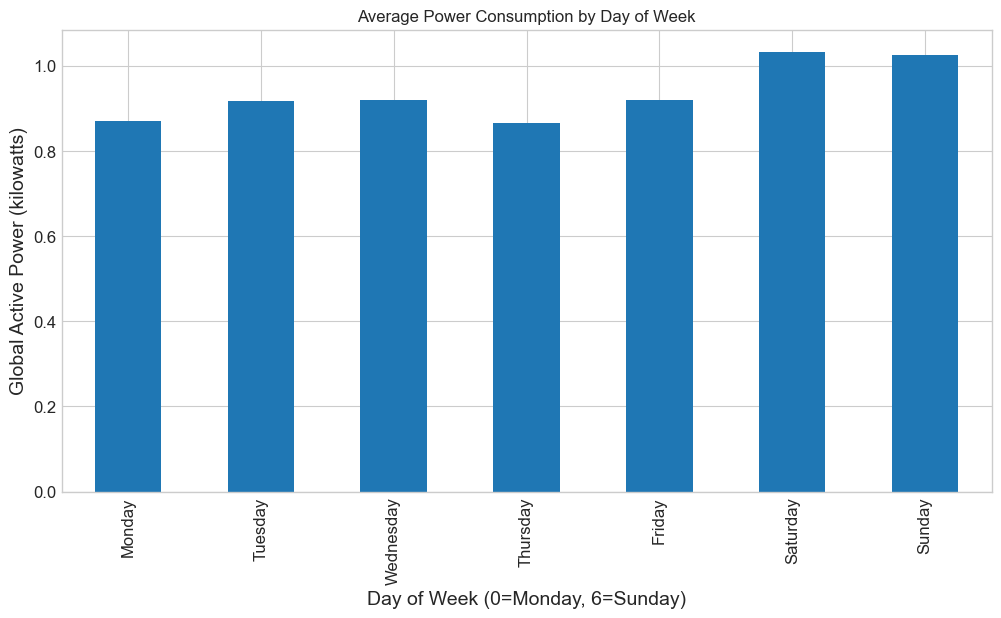

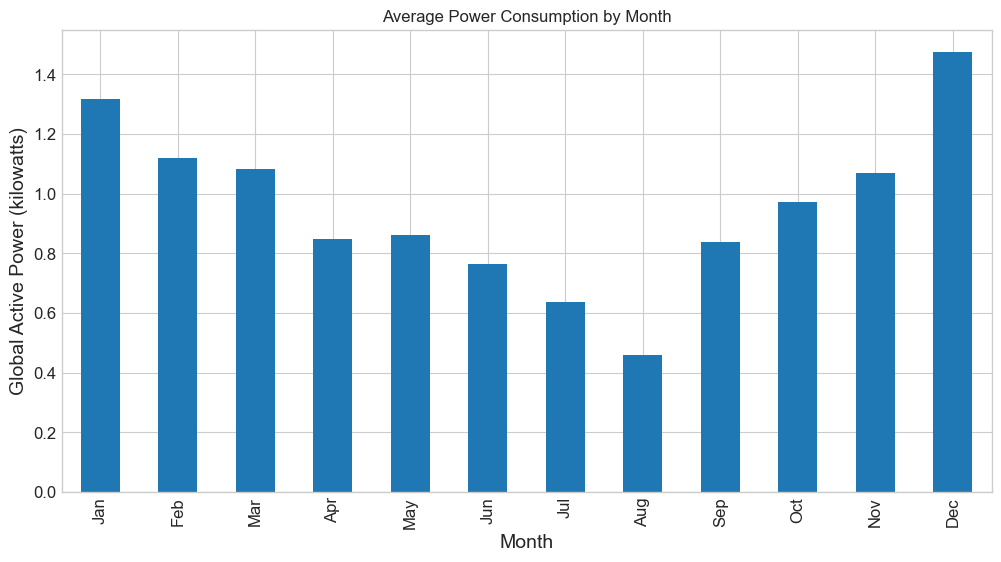

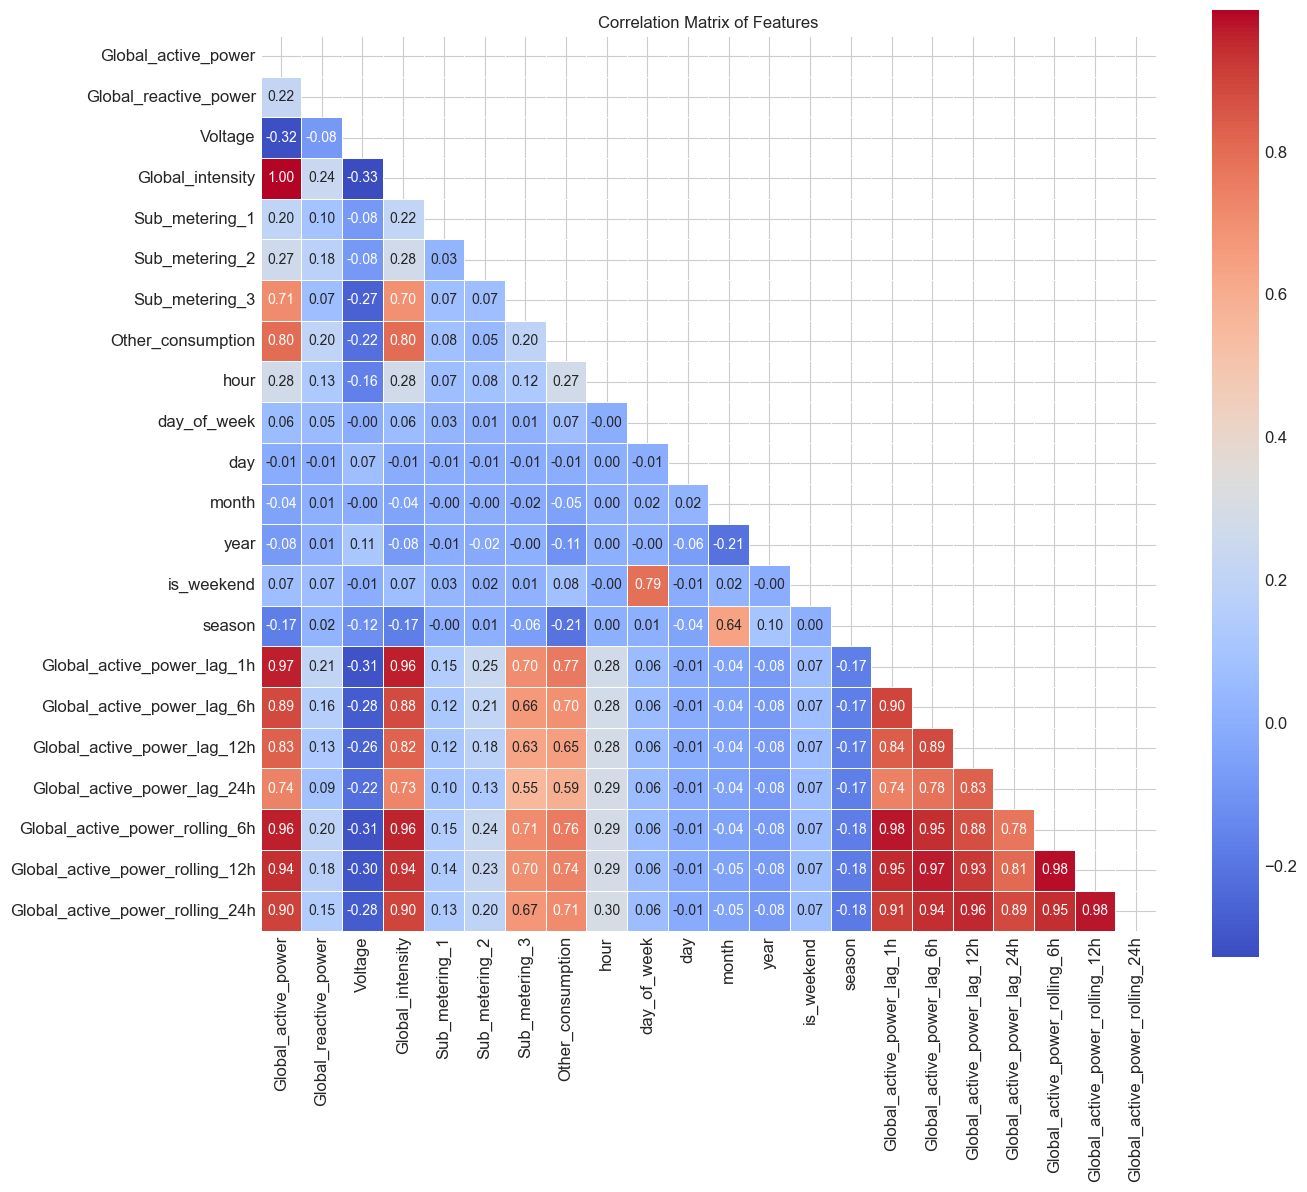

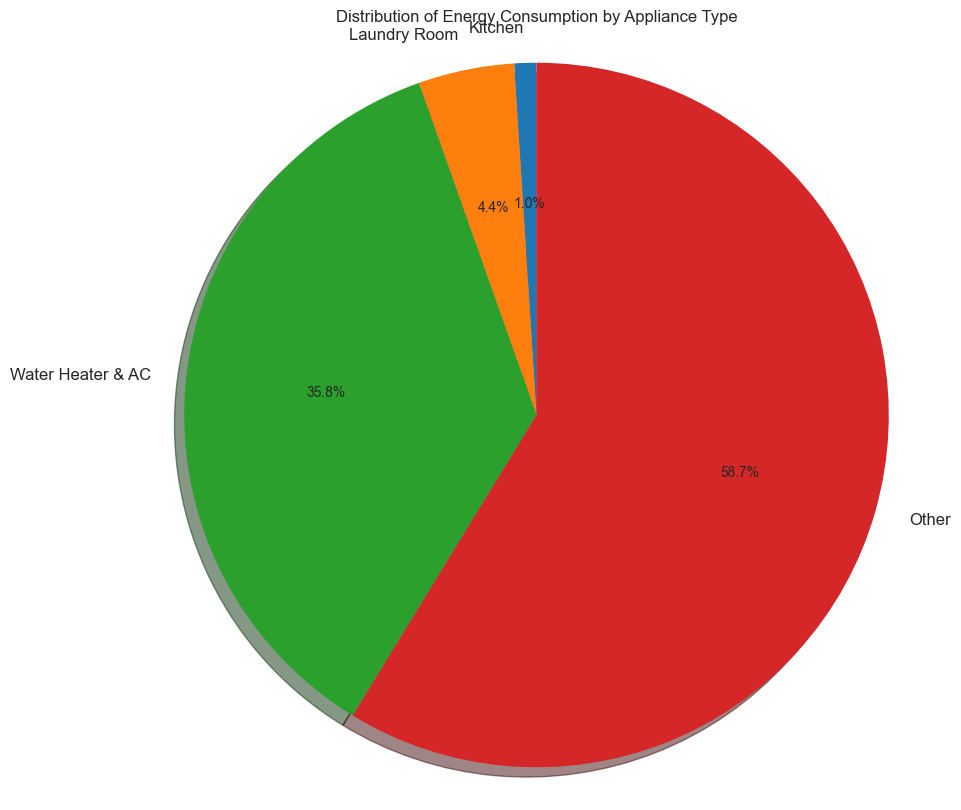

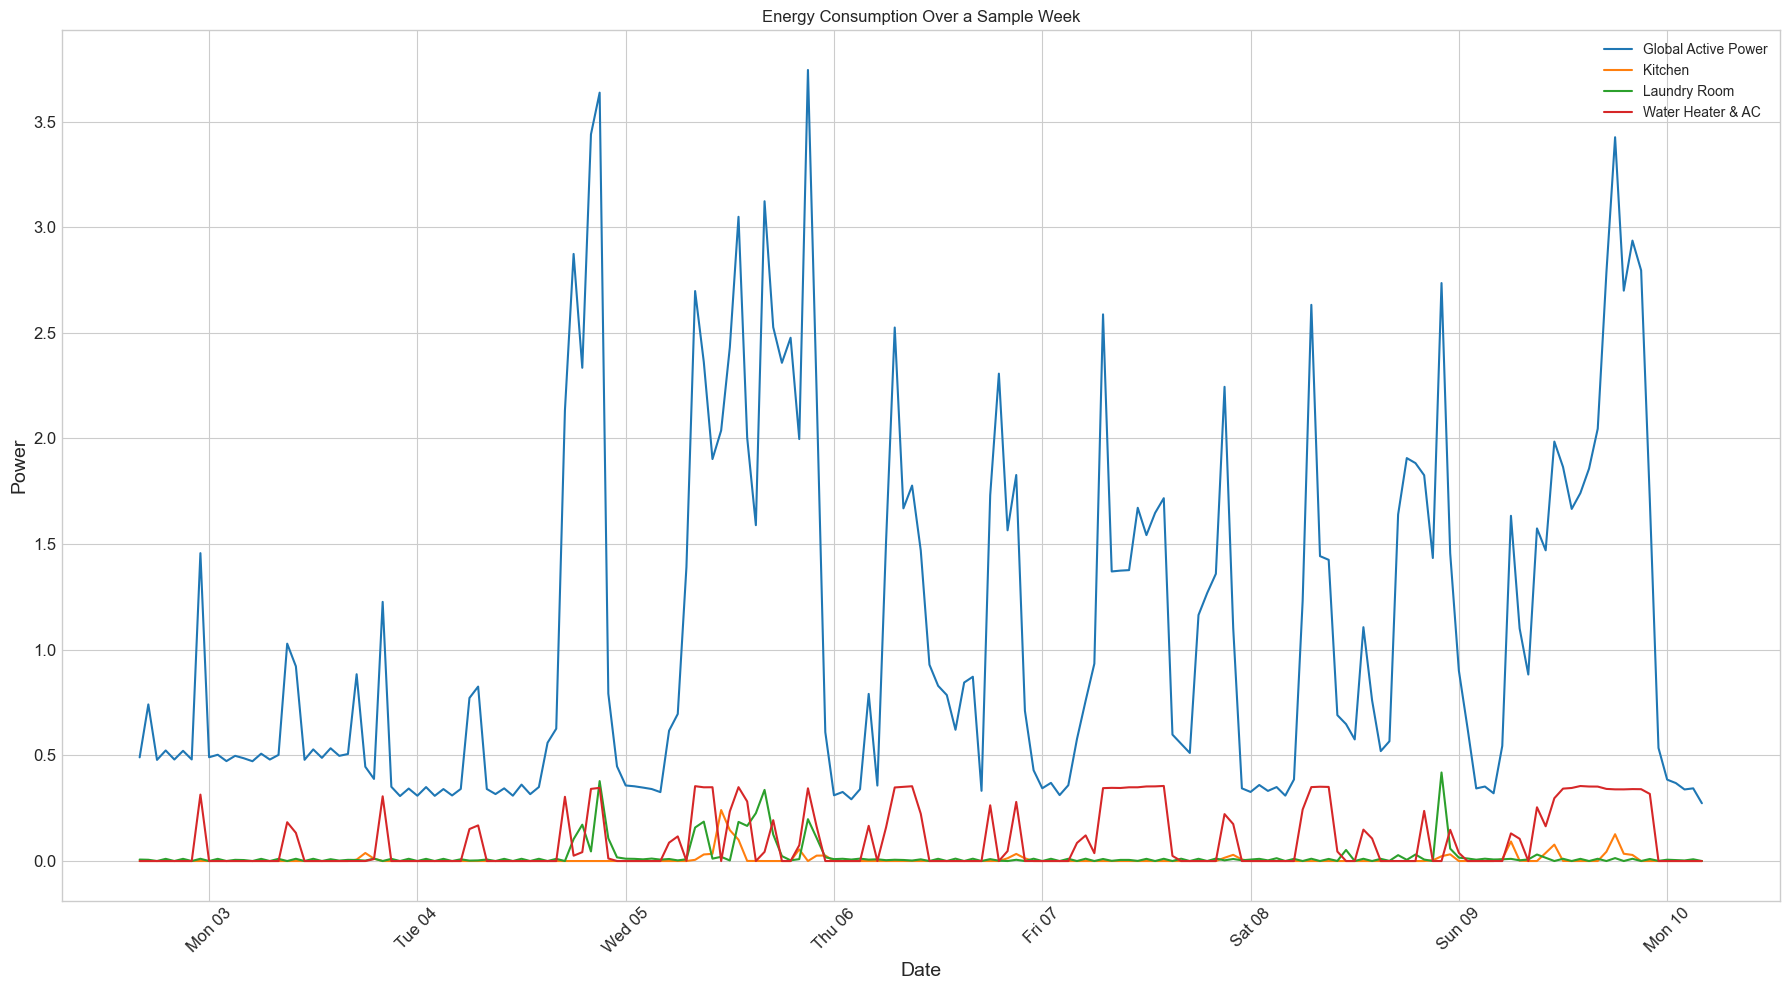

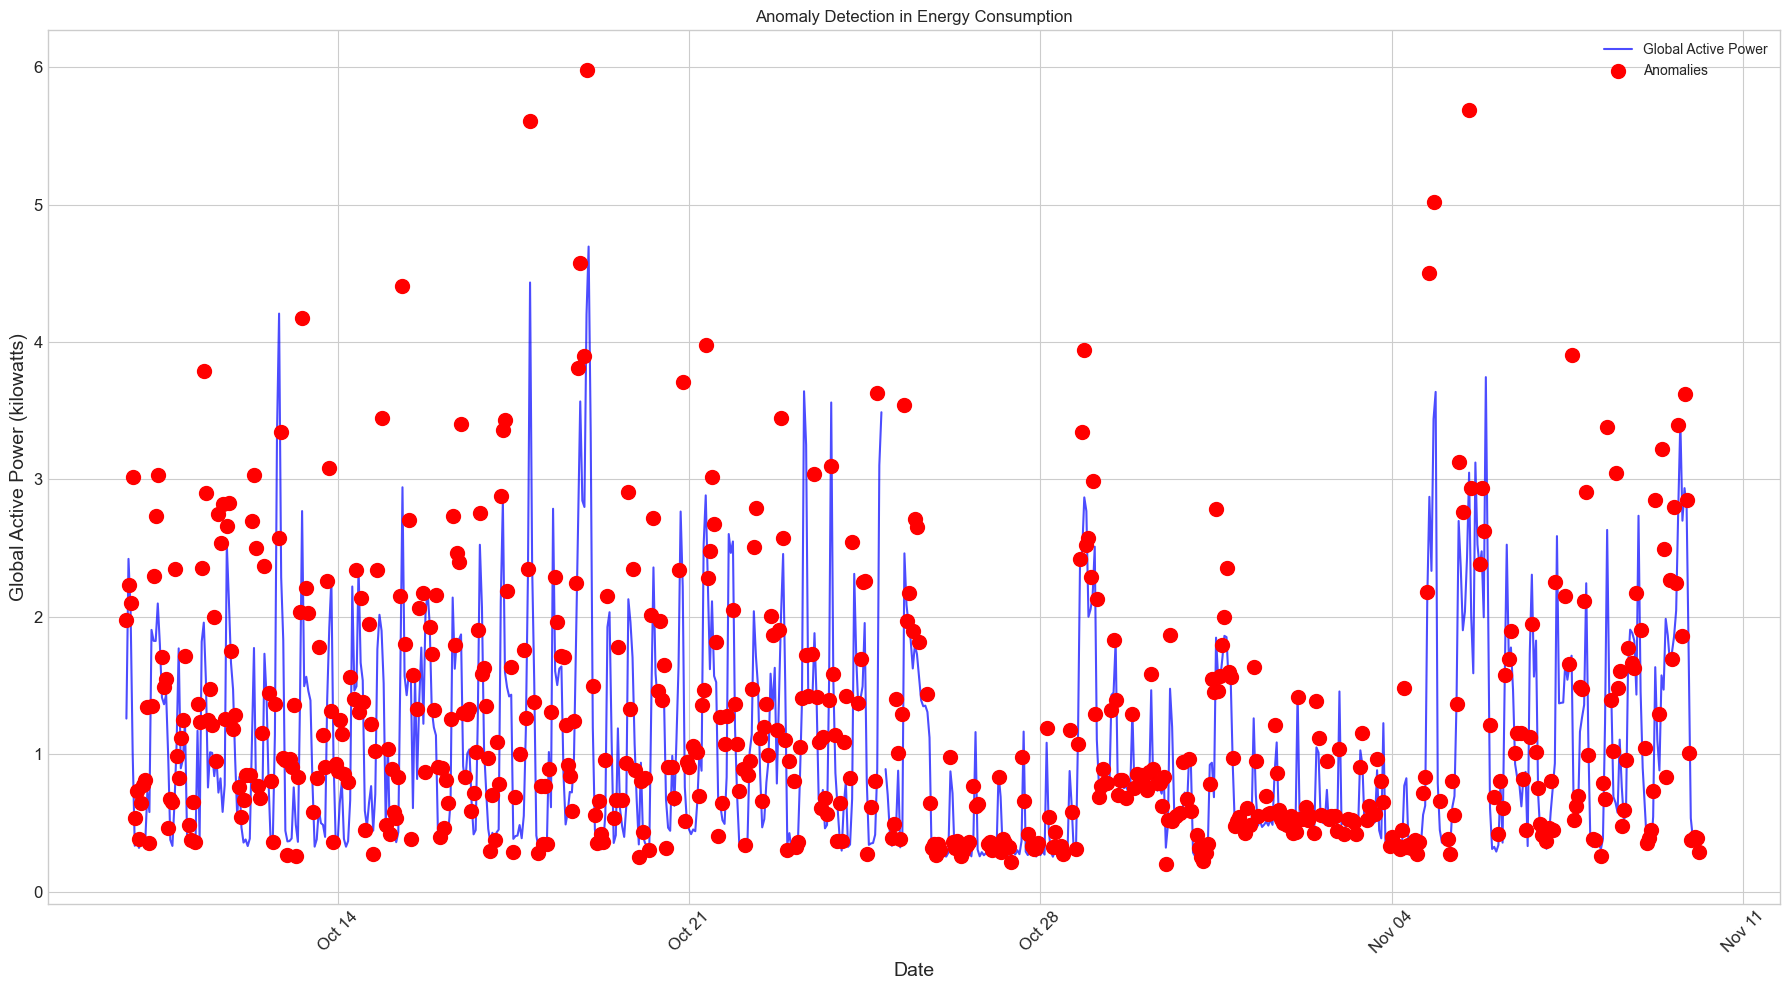

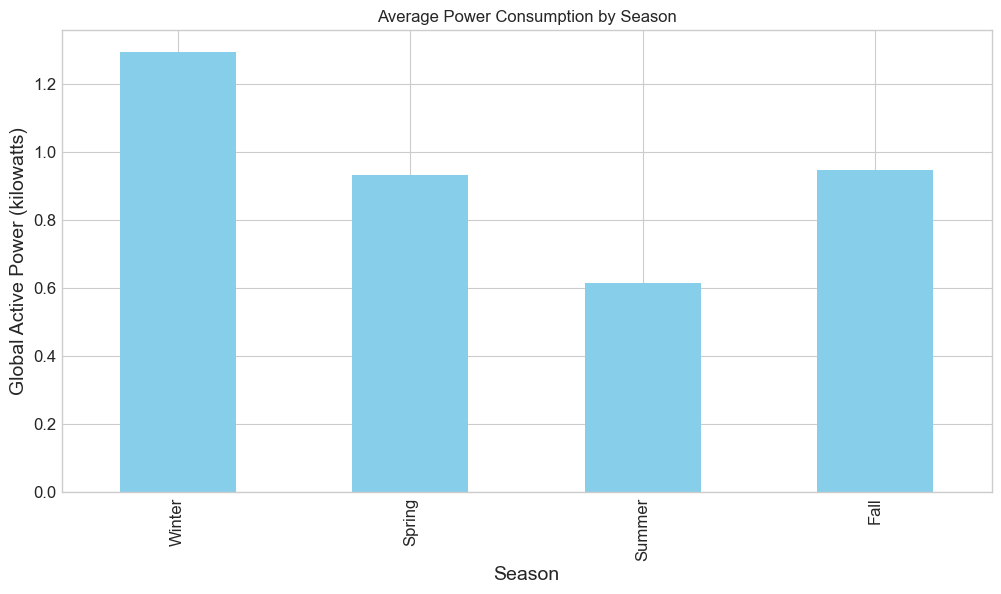

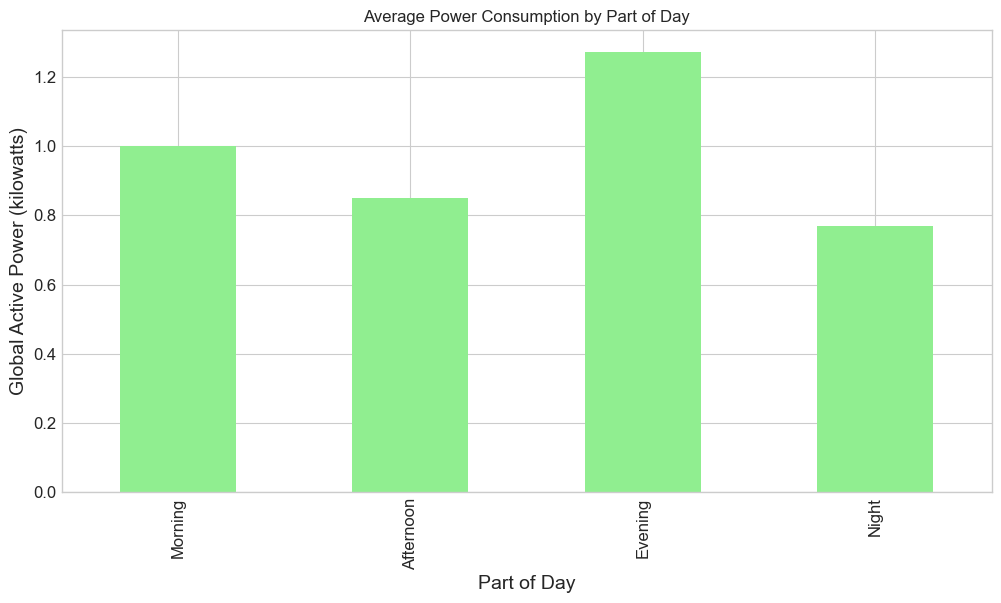

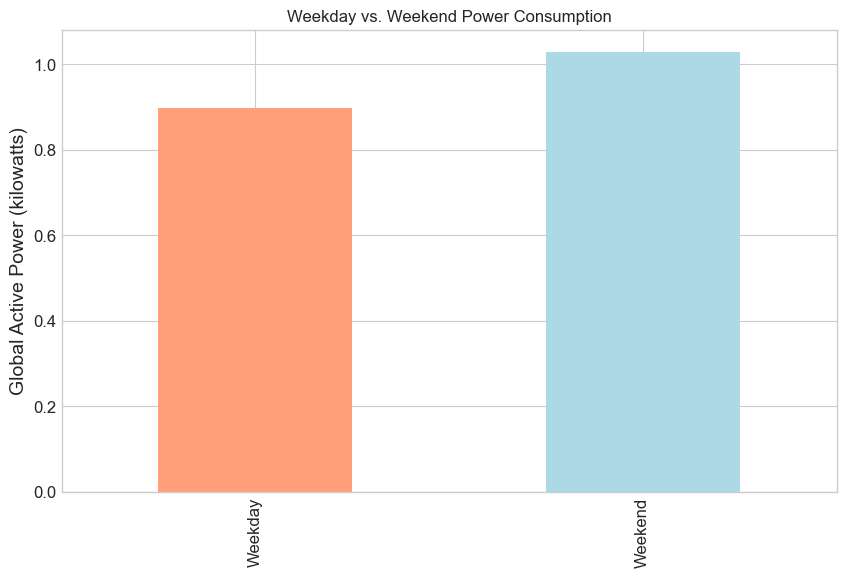

EDA completed. Plots displayed inline.

Scaling features...
Features scaled successfully.

Preparing data for modeling...
Training set size: (761229, 13)
Testing set size: (190308, 13)

Training and evaluating models...

1. Training XGBoost Regressor...
XGBoost RMSE: 0.0186
XGBoost MAE: 0.0073
XGBoost R²: 0.9993


<Figure size 1200x800 with 0 Axes>

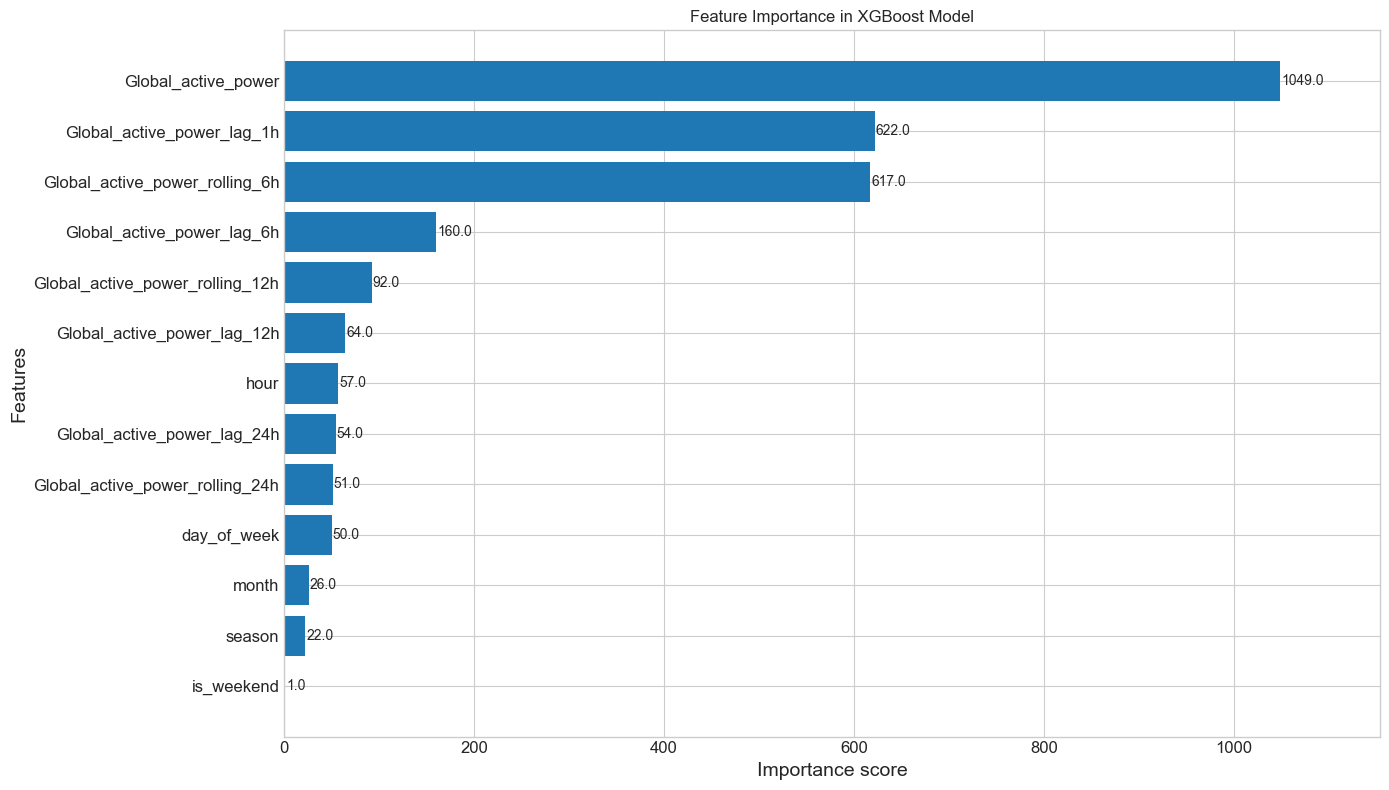


2. Training ARIMA model...
ARIMA model fitting failed. This could be due to non-stationarity or other time series issues.

3. Training Facebook Prophet model...


01:16:37 - cmdstanpy - INFO - Chain [1] start processing
01:16:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitting failed.

Model Performance Comparison:
XGBoost RMSE: 0.0186

Generating appliance-specific insights...


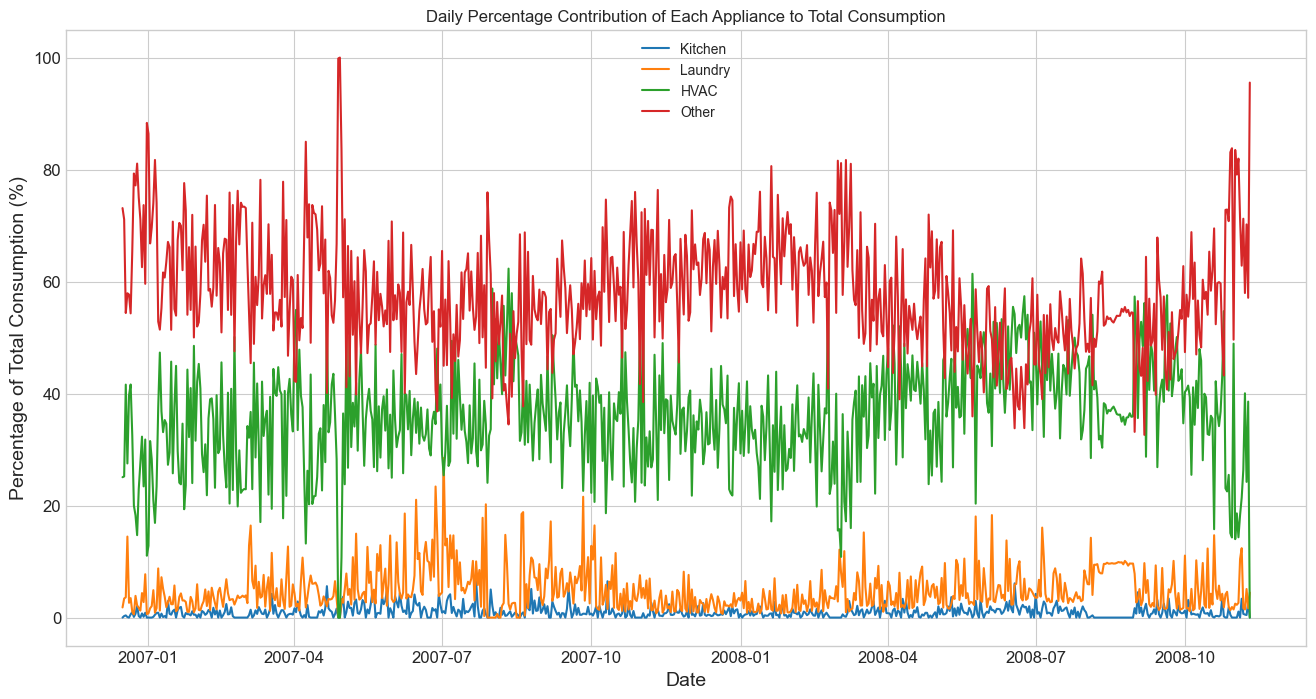

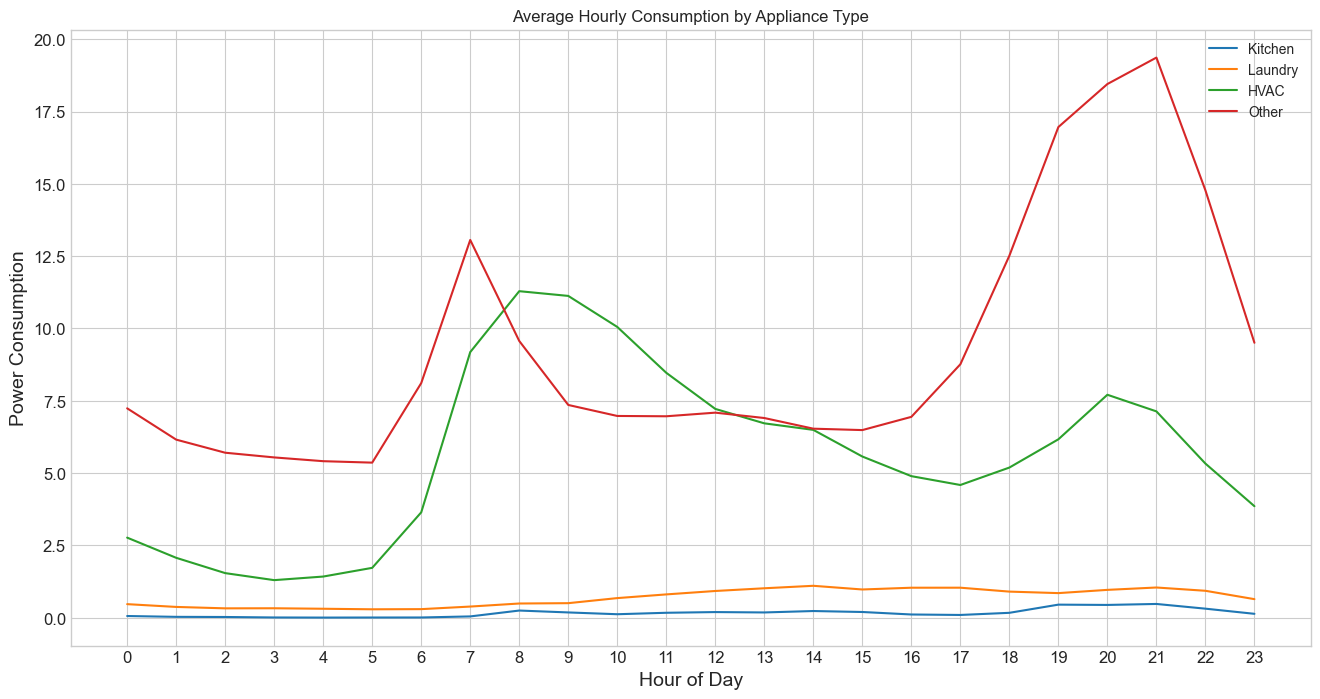

Peak usage times by appliance:
Kitchen: 21:00
Laundry: 14:00
HVAC: 8:00
Other appliances: 21:00


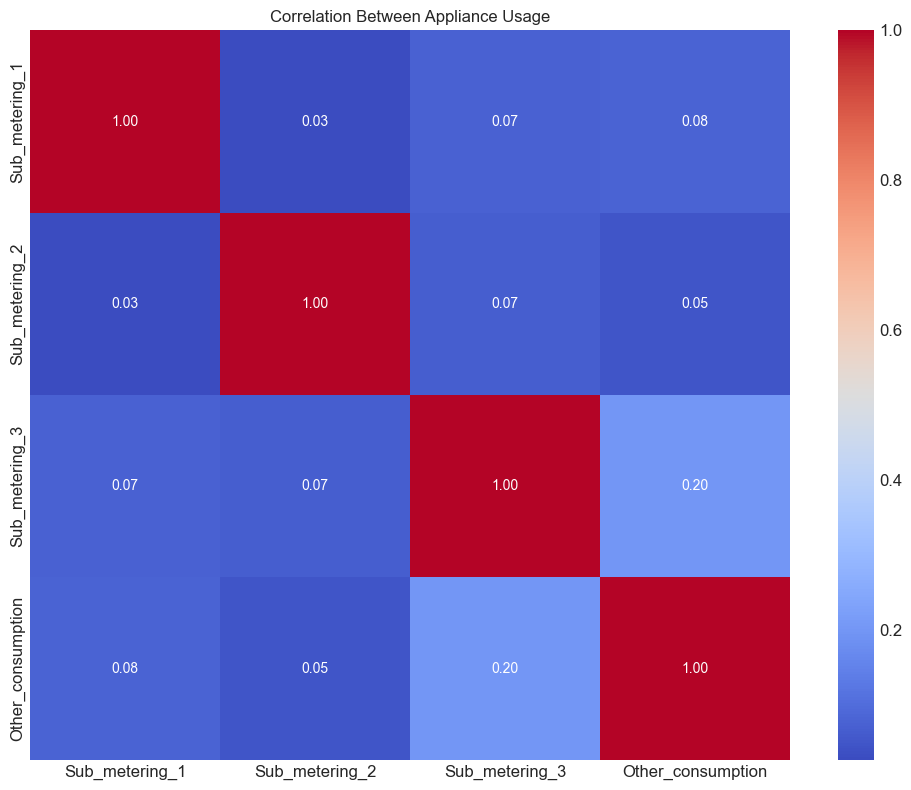

<Figure size 1400x1000 with 0 Axes>

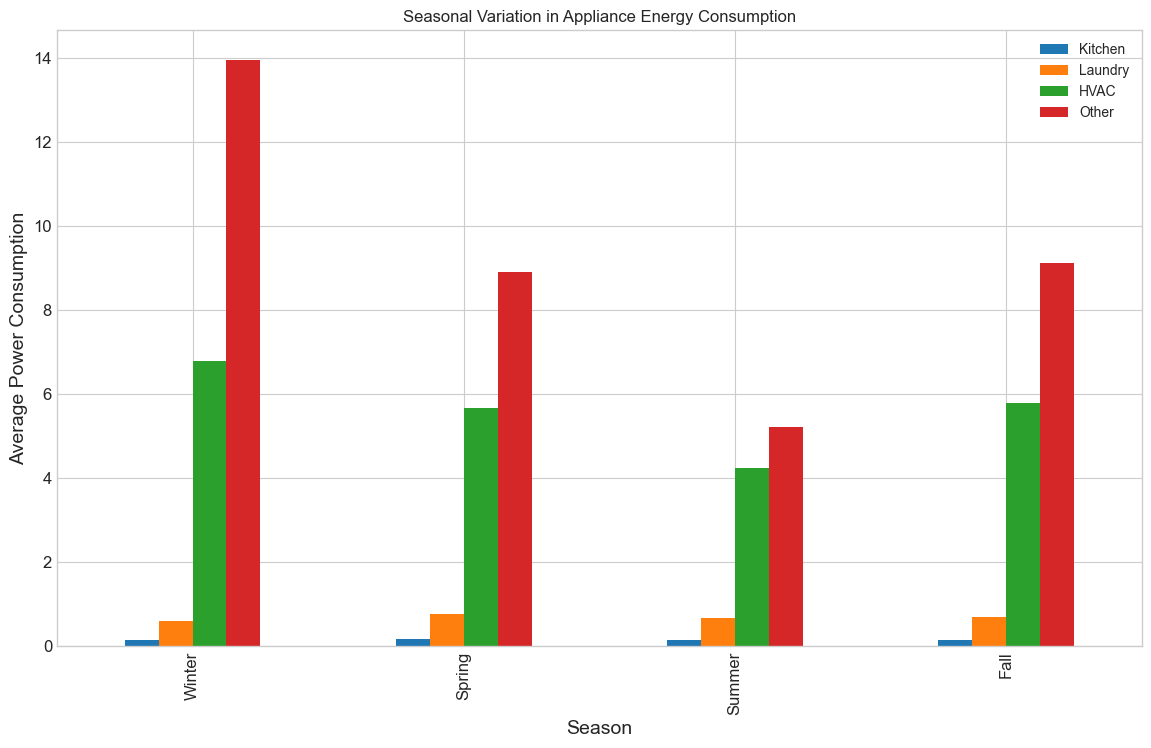


Potential energy savings by optimizing usage times:
Kitchen appliances: 0.47 units per hour
Laundry appliances: 0.81 units per hour
HVAC system: 9.99 units per hour
Other appliances: 14.01 units per hour

Generating energy optimization recommendations...
1. Shifting laundry activities from 14:00 to off-peak hours (22:00-7:00)
   could save approximately $2.06 per month.
4. Standby power consumption is 5.70 units during 1:00-4:00 AM.
   Consider using smart power strips to cut power to devices when not in use.
   Potential monthly savings: $11.98
6. Detected 12824 anomalous consumption patterns (1.35% of time periods).
   These could indicate inefficient appliance usage or malfunctions.
   Recommendation: Investigate appliances during these specific time periods.

General Energy Efficiency Recommendations:
 - Replace incandescent bulbs with LED lighting (up to 75% energy savings for lighting)
 - Ensure proper sealing on refrigerator and freezer doors
 - Unplug chargers and appliances w

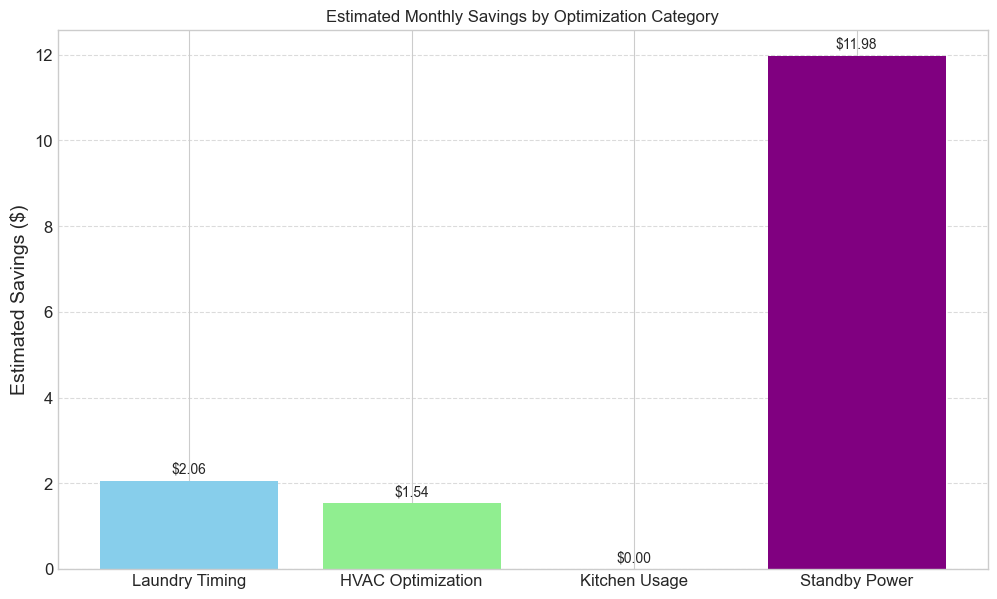

In [ ]:
def main(row_limit=None):
    print("Energy Consumption Analysis and Prediction Pipeline")
    print("=" * 50)
    
    file_path = 'household_power_consumption.csv'
    if not os.path.exists(file_path):
        print(f"Error: Dataset file '{file_path}' not found.")
        print("Please make sure the 'Individual Household Electric Power Consumption' dataset is in the current directory.")
        return
    
    df = load_and_preprocess_data(file_path, row_limit=row_limit)
    df_engineered = engineer_features(df)
    anomalies = perform_eda(df_engineered)
    df_scaled, scaler = scale_features(df_engineered)
    X_train, X_test, y_train, y_test = prepare_for_modeling(df_engineered)
    best_model, predictions, actuals = train_and_evaluate_models(X_train, X_test, y_train, y_test, df_engineered)
    kitchen_peak, laundry_peak, hvac_peak, other_peak = generate_appliance_insights(df_engineered)
    generate_recommendations(df_engineered, kitchen_peak, laundry_peak, hvac_peak, other_peak)
    
    

# Run the pipeline
main(row_limit=1000000)